In [1]:
import numpy as np

In [2]:
import PIL
from PIL import Image

In [3]:
import matplotlib
import math

In [4]:
import os
import random
import copy
from os import listdir
from collections import defaultdict

In [5]:
def load_data(data_dir="./aligned/"):
    """ Load all PNG images stored in your data directory into a list of NumPy
        arrays.

    Args:
    data_dir: The relative directory path to the CompCar image directory.
    Returns:
        images: A dictionary with keys as car types and a list containing images associated with each key.
        cnt: A dictionary that stores the # of images in each car type
    """
    images = defaultdict(list)

    # Get the list of car type directory:
    for e in listdir(data_dir):
        # excluding any non-directory files
        if not os.path.isdir(os.path.join(data_dir, e)):
            continue
        # Get the list of image file names
        all_files = listdir(os.path.join(data_dir, e))

        for file in all_files:
            # Load only image files as PIL images and convert to NumPy arrays
            if '.jpg' in file:
                img = Image.open(os.path.join(data_dir, e, file))
                images[e].append(np.array(img))

    print("Car types: {} \n".format(list(images.keys())))

    cnt = defaultdict(int)
    for e in images.keys():
        print("{}: {} # of images".format(e, len(images[e])))
        cnt[e] = len(images[e])
    return images, cnt


In [6]:
# this function takes in all the img from all set and return a list of sets of mutually exclusive images and its labels.
def k_fold(imgs, k):
    res = []
    for _ in range(k):
        res.append(defaultdict(list))
    for key in imgs.keys():
        for i, entry in enumerate(imgs[key]):
            res[i%k][key].append(entry)
    return res

In [7]:
def PCA(X, n_components):

    """Args:
        X: has shape Mxd where M is the number of images and d is the dimension of each image
        n_components: The number of components you want to project your image onto. 
    
    Returns:
        projected: projected data of shape M x n_components
        mean_image: mean of all images
        top_sqrt_eigen_values: singular values
        top_eigen_vectors: eigenvectors 
    """
    mean_image = np.average(X, axis = 0)

    msd = X - mean_image # M x d

    smart_cov_matrix = np.matmul(msd, msd.T)
    eigen_values, smart_eigen_vectors = np.linalg.eig(smart_cov_matrix)

    idx = eigen_values.argsort()[::-1]   
    eigen_values = eigen_values[idx]
    smart_eigen_vectors = smart_eigen_vectors[:,idx]

    eigen_vectors = (np.matmul(msd.T, smart_eigen_vectors)).T # M x d

    row_norm = np.sum(np.abs(eigen_vectors)**2,axis=-1)**(1./2) # M

    normalized_eigen_vectors = eigen_vectors/(row_norm.reshape(-1, 1)) # M x d

    top_eigen_vectors = normalized_eigen_vectors[:n_components].T
    top_sqrt_eigen_values = np.sqrt(eigen_values[:n_components])

    projected = np.matmul(msd, top_eigen_vectors)/top_sqrt_eigen_values

    return projected, mean_image, top_sqrt_eigen_values, top_eigen_vectors

In [8]:
img, cnt = load_data()
folds = k_fold(img, 10)
test, validation = folds[0], folds[1]
train = defaultdict(list)
for trainLoaderIter in range(2, 10):
    for key in folds[trainLoaderIter].keys():
        train[key].extend(folds[trainLoaderIter][key])
totalTrainingAmount = 0
for key in train.keys():
    totalTrainingAmount += len(train[key])

Car types: ['Convertible', 'Pickup', 'Minivan', 'Sedan'] 

Convertible: 149 # of images
Pickup: 150 # of images
Minivan: 148 # of images
Sedan: 150 # of images


In [9]:
print(totalTrainingAmount)

477


In [10]:
#newTrainingConvertable = train['Convertible']
X = []
y= []

for i in range(len(train['Convertible'])):
    X.append(train['Convertible'][i].reshape((-1)))
    y.append(0)
for i in range(len(train['Minivan'])):
    X.append(train['Minivan'][i].reshape((-1)))
    y.append(1)

X = np.array(X)
y = np.array(y).reshape(1, len(y)).T
#print(X.shape, y.shape)
#from sklearn.decomposition import PCA as skPCA

#pca = skPCA(n_components=)
#X = pca.fit_transform(X)
#print(X.shape)


In [25]:
projected, mean_image, top_sqrt_eigen_values, top_eigen_vectors = PCA(X, 4)

In [26]:
class Logistic_regression:
    def __init__(self, dimension, lr):
        self.lr = lr
        self.w = np.zeros(dimension)
        
    def sigmoid(self, X):
        return 1.0 / (1.0 + np.exp(-X))
    
    def caculateGradient(self, X, yTrue):
        expected = self.w @ X.T
        diffs = yTrue-expected.reshape((-1,1))
        gradient = (X*diffs).sum(axis=0)
        return gradient*(1/len(X))
        
    def updateWeight(self, X, yTrue):
        self.w = self.w + self.lr * self.caculateGradient(X, yTrue)
        
    def predict(self, X):
        return self.sigmoid(X@self.w.T)
    
    def score(self, X, yTrue):
        yCalculated = self.predict(X)
        correct = 0
        for i in range(len(X)):
            print(yCalculated[i], yTrue[i])
            if yCalculated[i] == yTrue[i]:
                correct += 1
        return correct / len(yCalculated)
    
    def logLikelihood(self, X, yTrue):
        expected = self.sigmoid(self.w @ X.T)
        LLs = yTrue*np.log(expected).reshape((-1,1)) + (1-yTrue)*np.log(1-expected).reshape((-1,1))
        return LLs.sum(axis=0)
    
    def fit(self, X, y, epoch):
        log = []
        for _ in range(epoch):
            self.updateWeight(X, y)
            log.append(self.logLikelihood(X, y))
        return log
    

In [27]:
LR = Logistic_regression(projected.shape[1], 0.02)
Loss = LR.fit(projected, y, 55000)

Text(0, 0.5, 'Log likelihood')

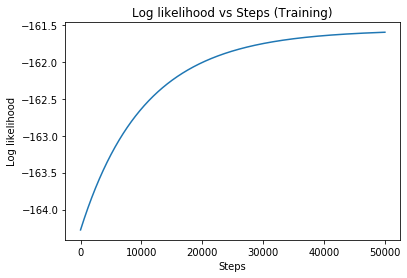

In [28]:
import matplotlib.pyplot as plt
plt.plot(Loss)
plt.title("Log likelihood vs Steps (Training)")
plt.xlabel("Steps")
plt.ylabel("Log likelihood")

In [ ]:
#(a) Implement Logistic Regression via Gradient Descent. (5 points)
#Now, without using any high-level machine learning libraries, implement logistic regression. Here, you’ll be using batch gradient descent, and will only need one logistic output unit. (Think about why we only need one if we’re classifying two classes?) The most points will be given for clean, well-documented code.
def gradient_descent(X, y, lr=0.05, epoch=300):
    '''
    Gradient Descent for a single feature
    X -> feature -> m * d
    y -> label -> m
    lr -> learning rate
    epoch -> epoch
    
    weights <-
    mse     <-
    '''
    
    weight = np.zeros((X.shape[1], 1))
    N = len(X) # number of samples
    log = []
    
    for _ in range(epoch):
        errorSum = np.zeros((X.shape[1], 1))
        #biasIncludedX = np.append(X, np.ones((X.shape[0], 1)), 1)
        calculatedTarget = X@weight
        #print(calculatedTarget, y)
        diffs = y - calculatedTarget
        #print(diffs.shape, y.shape, calculatedTarget.shape)
        for i, diff in enumerate(diffs):
            #print(diff.shape, errorSum.shape, X[i].shape)
            #print(diff[0])
            errorSum += diff[0] * X[i].reshape((-1, 1))
        weight += errorSum * lr * (2/N)
        #print(weight)
        log.append(sum(diffs**2)[0])

    return weight, log

In [ ]:
w, l = gradient_descent(X, y)

In [ ]:
print(l)

In [ ]:
def PCA_test(X, mean_image, n_components):
    msd = X - mean_image # M x d

    smart_cov_matrix = np.matmul(msd, msd.T)
    eigen_values, smart_eigen_vectors = np.linalg.eig(smart_cov_matrix)

    idx = eigen_values.argsort()[::-1]   
    eigen_values = eigen_values[idx]
    smart_eigen_vectors = smart_eigen_vectors[:,idx]

    eigen_vectors = (np.matmul(msd.T, smart_eigen_vectors)).T # M x d

    row_norm = np.sum(np.abs(eigen_vectors)**2,axis=-1)**(1./2) # M

    normalized_eigen_vectors = eigen_vectors/(row_norm.reshape(-1, 1)) # M x d

    top_eigen_vectors = normalized_eigen_vectors[:n_components].T
    top_sqrt_eigen_values = np.sqrt(eigen_values[:n_components])

    projected = np.matmul(msd, top_eigen_vectors)/top_sqrt_eigen_values

    return projected

In [ ]:
pca = PCA(n_components=4)
pca.fit()
reg = LinearRegression().fit(X, y)
reg.score(X, y)

In [ ]:
print(reg.predict(X))

In [ ]:

#(a) Implement Logistic Regression via Gradient Descent. (5 points)
#Now, without using any high-level machine learning libraries, implement logistic regression. Here, you’ll be using batch gradient descent, and will only need one logistic output unit. (Think about why we only need one if we’re classifying two classes?) The most points will be given for clean, well-documented code.
def gradient_descent(X, y, lr=0.05, epoch=300):
    '''
    Gradient Descent for a single feature
    X -> feature -> m * d
    y -> label -> m
    lr -> learning rate
    epoch -> epoch
    
    weights <-
    mse     <-
    '''
    
    weight = np.zeros((projected.shape[1], 1))
    N = len(X) # number of samples
    log = []
    #log, mse = [], [] # lists to store learning process
    # M * (d+1)--> X with last be bias term (feature)
    # M * 1    --> y --> lable
    
    for _ in range(epoch):
        errorSum = np.zeros((X.shape[1], 1))
        #biasIncludedX = np.append(X, np.ones((X.shape[0], 1)), 1)
        calculatedTarget = X@weight
        #print(calculatedTarget, y)
        diffs = y - calculatedTarget
        #print(diffs.shape, y.shape, calculatedTarget.shape)
        for i, diff in enumerate(diffs):
            #print(diff.shape, errorSum.shape, X[i].shape)
            #print(diff[0])
            errorSum += diff[0] * X[i].reshape((-1, 1))
        weight += errorSum * lr * (2/N)
        log.append(sum(diffs**2)[0])

    return weight, log

In [ ]:
#newTrainingMiniVan = train['Minivan']
#newTrainingConvertable = train['Convertible']
y = []
X = []
for i in range(len(memo)):
    if memo[i][0] == 'Convertible':
        y.append(0)
        X.append(projected[i])
    elif memo[i][0] == 'Minivan':
        y.append(1)
        X.append(projected[i])
X = np.array(X)
y = np.array(y).reshape(1, len(y)).T

In [ ]:
print(X.shape)
print(y.shape)

In [ ]:
w, l = gradient_descent(X, y)
print(l)

In [ ]:
validationConvertable = test['Convertible']
validationMinivan     = test['Minivan']

validationPCAed = []
validationY = []
for i in range(len(validationConvertable)):
    validationPCAed.append((np.matmul(validationConvertable[i].reshape(1, 60000) - mean_image, top_eigen_vectors)/top_sqrt_eigen_values)[0])
    validationY.append(0)
for i in range(len(validationMinivan)):
    validationPCAed.append((np.matmul(validationMinivan[i].reshape(1, 60000) - mean_image, top_eigen_vectors)/top_sqrt_eigen_values)[0])
    validationY.append(1)

In [ ]:
print(len(validationPCAed))
validationPCAed = np.array(validationPCAed)
print(validationPCAed.shape[0])

In [ ]:
validationPCAed = np.append(validationPCAed, np.ones((validationPCAed.shape[0], 1)), 1)

In [ ]:
validationPCAed@w

In [ ]:
validationPCAed